# TP2 Deep Learning Implementation
- 2nd stage Preprocessing
- Hyperparameter Tuning
- Error Analysis


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving automobile_prepared.csv to automobile_prepared.csv
Saving DF_OHE_ver2.csv to DF_OHE_ver2.csv


In [ ]:
import pandas as pd

df = pd.read_csv('DF_OHE_ver2.csv',  index_col=0)
df_Original = pd.read_csv('automobile_prepared.csv',  index_col=0)

Now carry out the datasplit into the training dataset and the test dataset

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Entrenamiento
X_train = train.drop(['remainder__lnprice'], axis=1)
y_train = train['remainder__lnprice']
y_train= pd.DataFrame(y_train, columns = ['remainder__lnprice'])

# Testing
X_test = test.drop(['remainder__lnprice'], axis=1)
y_test = test['remainder__lnprice']
y_test= pd.DataFrame(y_test, columns = ['remainder__lnprice'])

## Hyperparameter Tuning using HPARAMS Dashboard
https://analyticsindiamag.com/parameter-tuning-tensorboard/


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([20, 30, 100]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'nadam'])) #'sgd',
#HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
#HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([20, 100, 200]))

METRIC_RMSE = 'RootMeanSquaredError'


with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1, HP_DROPOUT, HP_OPTIMIZER], #, HP_L2,, HP_NUM_UNITS_2
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

Source: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

The `ModelCheckpoint callback` is flexible in the way it can be used, but in this case we will use it only to save the best model observed during training as defined by a chosen performance measure on the validation dataset.

we are interested in only the very best model observed during training, rather than the best compared to the previous epoch, which might not be the best overall if training is noisy. This can be achieved by setting the “save_best_only” argument to True.



```
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

```

It may be interesting to know the value of the performance measure and at what epoch the model was saved. This can be printed by the callback by setting the “verbose” argument to “1“.
 

```
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)

```



Saving and loading models requires that `HDF5` support has been installed on your workstation. For example, using the pip Python installer, this can be achieved as follows:



```
sudo pip install h5py
```


The saved model can then be loaded and evaluated any time by calling the load_model() function.



```
# load a saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')
```





In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here, I try Deep Neural Network. 

In order to receive the training dataset, `X_train`, the input layer has to have the input shape of the number of its features.

And of course, the output layer has to have only one single node to generate the price estimation.


In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = X_train.shape[1]),   
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),

    tf.keras.layers.Dense(1)
  ])
    

  model.compile(
      #optimizer=hparams[HP_OPTIMIZER],
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['RootMeanSquaredError'],
  )

  
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000) # callbacks=[callback]
  
  _, train_rmse = model.evaluate(X_train, y_train)
  _, test_rmse = model.evaluate(X_test, y_test)
  return train_rmse, test_rmse

In [ ]:
#A function to log the training process
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  
    train_rmse, test_rmse = train_test_model(hparams)
    tf.summary.scalar(METRIC_RMSE, test_rmse, step=10)

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
     # for num_units_2 in HP_NUM_UNITS_2.domain.values:
        hparams = {
          HP_NUM_UNITS_1: num_units_1,
          HP_DROPOUT: dropout_rate,
          #HP_NUM_UNITS_2: num_units_2, 
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 22ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679 - val_loss: 0.0791 - val_root_mean_squared_error: 0.2813
Epoch 507/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0364 - root_mean_squared_error: 0.1909 - val_loss: 0.0774 - val_root_mean_squared_error: 0.2783
Epoch 508/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3275
Epoch 509/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0298 - root_mean_squared_error: 0.1725 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2900
Epoch 510/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0306 - root_mean_squared_error: 0.1750 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2810
Epoch 511/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0238 - root_mean_squar

Check the following link to fix the problem:
https://stackoverflow.com/questions/67750424/tensorboard-error-failed-to-launch-tensorboard-exited-with-1-contents-of-std


In [ ]:
#!kill 647

In [ ]:
%tensorboard --logdir logs/hparam_tuning

This cell output is too large and can only be displayed while logged in.


In [ ]:
stop & check

NameError: ignored

The lowest value of the performance metric, RMSE, was generated by the following set of hyperparameter values:

<font color=red> 

{HP_NUM_UNITS_1: 100, HP_DROPOUT: 0.3, HP_OPTIMIZER: 'adam'}
</font>

Now, we can register these values as the tuned hyperparameter values into the hyperparameter dictionary, `tuned_hparams`.


# <font color=red>　　　　　　　↑
# <font color=red> STOP: Check the best validation performance point and apply 
#<font color=red>　　　　　　　 ↓

In [ ]:
tuned_hparams = {HP_NUM_UNITS_1: 30, HP_DROPOUT: 0.1, HP_OPTIMIZER:'nadam'}


Use the tuned hyperparameter values to compare the performance meterics between the train dataset and the test dataset to assess **bias-variance tradeoff**.


In [ ]:


def bias_variance_tradeoff(tuned_hparams):

  model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.layers.InputLayer(input_shape = X_train.shape[1]),   
    tf.keras.layers.Dense(tuned_hparams[HP_NUM_UNITS_1], activation=tf.nn.relu,  kernel_initializer = 'uniform'),
    tf.keras.layers.Dropout(tuned_hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])
    

  model.compile(
      optimizer=tuned_hparams[HP_OPTIMIZER],
      loss='mean_squared_error',
      metrics=['RootMeanSquaredError'],
   )
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
  
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  
  tuned_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, callbacks=[mc]) # callbacks=[callback]
  
  
  # load the saved model
  tuned_saved_model = load_model('best_model.h5')

  #calculater performance meterics
  _, tuned_train_rmse = model.evaluate(X_train, y_train)
  _, tuned_test_rmse = model.evaluate(X_test, y_test)
  
  return tuned_history, tuned_train_rmse, tuned_test_rmse, tuned_saved_model

In [ ]:
tuned_history, tuned_train_rmse, tuned_test_rmse,  tuned_saved_model = bias_variance_tradeoff(tuned_hparams)

Epoch 1/2000
5/5 [==============================] - 5s 101ms/step - loss: 85.6917 - root_mean_squared_error: 9.2570 - val_loss: 84.8145 - val_root_mean_squared_error: 9.2095
Epoch 2/2000
5/5 [==============================] - 0s 31ms/step - loss: 85.1151 - root_mean_squared_error: 9.2258 - val_loss: 84.0438 - val_root_mean_squared_error: 9.1675
Epoch 3/2000
5/5 [==============================] - 0s 31ms/step - loss: 84.1661 - root_mean_squared_error: 9.1742 - val_loss: 82.5969 - val_root_mean_squared_error: 9.0883
Epoch 4/2000
5/5 [==============================] - 0s 36ms/step - loss: 82.2514 - root_mean_squared_error: 9.0693 - val_loss: 79.1436 - val_root_mean_squared_error: 8.8963
Epoch 5/2000
5/5 [==============================] - 0s 32ms/step - loss: 76.9447 - root_mean_squared_error: 8.7718 - val_loss: 67.0805 - val_root_mean_squared_error: 8.1903
Epoch 6/2000
5/5 [==============================] - 0s 31ms/step - loss: 58.8052 - root_mean_squared_error: 7.6685 - val_loss: 32.4164

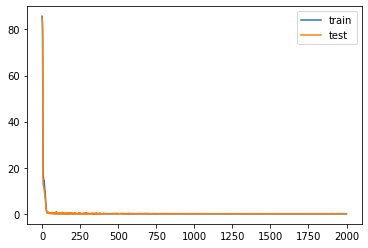

In [ ]:
from matplotlib import pyplot
pyplot.plot(tuned_history.history['loss'], label='train')
pyplot.plot(tuned_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
_, train_rmse =  tuned_saved_model.evaluate(X_train, y_train, verbose=0)
_, test_rmse =  tuned_saved_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
train_rmse

0.2155793011188507

In [ ]:
test_rmse

0.3095873296260834

In [ ]:
print('The performance metric for the training dataset and the valuation metric for the testing dataset converged: \nTrain: %.3f, Test: %.3f' % (train_rmse, test_rmse))

The performance metric for the training dataset and the valuation metric for the testing dataset converged: 
Train: 0.216, Test: 0.310


In [ ]:
saved_model = load_model('best_model.h5')

In [ ]:
prediction=saved_model.predict(X_test)

2/2 [==============================] - 0s 10ms/step


In [ ]:
prediction

array([[ 8.873419 ],
       [ 8.888666 ],
       [ 9.74484  ],
       [ 9.609738 ],
       [ 9.105604 ],
       [ 8.763953 ],
       [ 8.962055 ],
       [ 8.787781 ],
       [ 9.596983 ],
       [ 9.724193 ],
       [ 9.171309 ],
       [ 8.893249 ],
       [ 8.872612 ],
       [ 8.985508 ],
       [ 9.171316 ],
       [ 9.101035 ],
       [ 8.458981 ],
       [10.030741 ],
       [ 8.999611 ],
       [ 8.822553 ],
       [ 9.208638 ],
       [ 9.146638 ],
       [ 9.599474 ],
       [ 9.37281  ],
       [ 8.3478985],
       [ 9.148539 ],
       [ 9.145006 ],
       [ 9.957247 ],
       [ 9.048633 ],
       [ 9.898698 ],
       [ 8.449499 ],
       [ 9.03015  ],
       [ 8.932633 ],
       [ 9.031129 ],
       [ 9.529623 ],
       [ 9.410725 ],
       [ 9.488327 ],
       [ 9.493    ],
       [ 8.796083 ],
       [10.463573 ],
       [10.2384405],
       [ 9.501232 ],
       [ 8.9957   ],
       [10.118988 ],
       [ 9.027369 ],
       [ 9.598492 ],
       [ 9.329222 ],
       [ 9.51

In [ ]:
y_test.index

Int64Index([ 15,   9, 115,  78,  66,  45, 132, 161, 201, 181,  69, 163, 167,
            152,  56, 191,  18,  79,  55, 146, 177,  97,  95,  30, 127,  16,
            174,  86, 135, 124,  65,  68, 128,  67,  76, 100, 140, 138, 144,
             84,  82, 199,  93,  38,  24,  96, 111,  29,  19,  60, 155, 168,
             90,   5, 153, 118, 193, 143, 190, 176,  73, 173],
           dtype='int64')

In [ ]:
type(y_test)

pandas.core.frame.DataFrame

In [ ]:
y_test.shape

(62, 1)

In [ ]:
prediction.shape

(62, 1)

In [ ]:
type(prediction)

numpy.ndarray

In [ ]:
prediction=pd.DataFrame(prediction, columns = ['lnprice'])

In [ ]:
type(prediction)

pandas.core.frame.DataFrame

In [ ]:
prediction["Key-ID"]=y_test.index

In [ ]:
prediction=prediction.set_index('Key-ID')

In [ ]:
prediction

,lnprice
Key-ID,
15,8.873419
9,8.888666
115,9.744840
78,9.609738
66,9.105604
...,...
143,8.654945
190,9.172020
176,9.261246


In [ ]:
prediction_sorted=prediction.sort_index(ascending=True)

In [ ]:
prediction_sorted

,lnprice
Key-ID,
5,8.712085
9,8.888666
15,8.873419
16,9.148539
18,8.458981
...,...
190,9.172020
191,9.101035
193,9.405010


In [ ]:
y_test_sorted=y_test.sort_index(ascending=True)

In [ ]:
y_test_sorted.rename(columns = {'remainder__lnprice':'lnprice'}, inplace = True)
y_test_sorted

,lnprice
5,8.533460
9,8.916640
15,9.696094
16,8.359837
18,8.509363
...,...
190,9.495143
191,9.535679
193,9.468079
199,9.731809


In [ ]:
type(y_test_sorted)

pandas.core.frame.DataFrame

In [ ]:
X_test = test.drop(['remainder__lnprice'], axis=1)

In [ ]:
X_test.head(3)

,one-hot-encoder__make_alfa-romero,one-hot-encoder__make_audi,one-hot-encoder__make_bmw,one-hot-encoder__make_chevrolet,one-hot-encoder__make_dodge,one-hot-encoder__make_honda,one-hot-encoder__make_isuzu,one-hot-encoder__make_mazda,one-hot-encoder__make_mercedes-benz,one-hot-encoder__make_mercury,...,remainder__length,remainder__width,remainder__curb-weight,remainder__num-of-cylinders,remainder__engine-size,remainder__bore,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854584,-0.762999,0.854793,-1.0,-1.222786,1.982875,1.083377,-1.266342,1.618825,-0.344549
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.080473,-2.632736,-0.376324,-1.0,-1.040125,1.982875,0.309467,0.921918,1.064491,-0.206609
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.259693,1.059993,1.078449,0.0,1.517115,0.218081,1.636170,0.062956,-1.014262,-0.758369


In [ ]:
X_test.sort_index(inplace=True)
X_test

,one-hot-encoder__make_alfa-romero,one-hot-encoder__make_audi,one-hot-encoder__make_bmw,one-hot-encoder__make_chevrolet,one-hot-encoder__make_dodge,one-hot-encoder__make_honda,one-hot-encoder__make_isuzu,one-hot-encoder__make_mazda,one-hot-encoder__make_mercedes-benz,one-hot-encoder__make_mercury,...,remainder__length,remainder__width,remainder__curb-weight,remainder__num-of-cylinders,remainder__engine-size,remainder__bore,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.542898,-1.230433,-1.250800,0.0,-1.274974,1.982875,-1.487109,-0.457204,-0.044177,-1.172189
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.080473,-2.632736,-0.376324,-1.0,-1.040125,1.982875,0.309467,0.921918,1.064491,-0.206609
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854584,-0.762999,0.854793,-1.0,-1.222786,1.982875,1.083377,-1.266342,1.618825,-0.344549
16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.781767,-1.230433,0.022630,0.0,-1.092314,1.982875,0.033071,1.438093,-0.459928,-0.344549
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.400035,-1.697867,-1.492591,0.0,-0.518240,-1.113255,-0.160406,-1.784509,1.341658,-1.172189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480561,0.592559,0.252332,0.0,0.342872,-0.524990,0.254188,0.660842,-1.014262,-0.896309
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480561,0.592559,0.087108,-1.0,-0.674805,-1.082293,-0.906676,-1.332109,0.925908,1.034851
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.150686,0.732790,0.758077,-1.0,0.473344,1.301727,0.364747,0.461547,-0.459928,-0.344549
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.150686,1.527428,0.838674,-1.0,0.473344,1.301727,0.364747,0.461547,-0.459928,-0.344549


In [ ]:
Key_list=X_test.index
Key_list

Int64Index([  5,   9,  15,  16,  18,  19,  24,  29,  30,  38,  45,  55,  56,
             60,  65,  66,  67,  68,  69,  73,  76,  78,  79,  82,  84,  86,
             90,  93,  95,  96,  97, 100, 111, 115, 118, 124, 127, 128, 132,
            135, 138, 140, 143, 144, 146, 152, 153, 155, 161, 163, 167, 168,
            173, 174, 176, 177, 181, 190, 191, 193, 199, 201],
           dtype='int64')

In [ ]:
df_Original.head()

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,lnprice
Key_ID,,,,,,,,,,,,,,,,,,,,,
0,toyota,gas,turbo,two,hatchback,fwd,front,-0.625271,-2.184354,-0.295565,...,0.734287,spdi,-1.113255,-0.698560,-0.509347,-1.404190,-0.305740,2.034576,-1.999829,8.433159
1,mitsubishi,diesel,std,four,convertible,rwd,front,0.190238,-2.028511,0.171869,...,-0.074637,2bbl,1.982875,-0.698560,2.187148,0.751701,1.318515,-0.044177,-0.344549,8.487764
2,volkswagen,diesel,std,four,hardtop,rwd,front,0.190238,-0.392159,0.171869,...,0.108024,mfi,-1.113255,2.301071,-0.509347,-0.934316,1.475959,-0.737095,-0.482489,8.756682
3,subaru,diesel,std,four,hatchback,fwd,front,2.799867,0.698741,0.639303,...,-1.170597,idi,1.982875,-0.698560,-0.264212,-1.127793,1.121213,3.143244,3.655711,9.477845
4,peugot,gas,std,four,hardtop,fwd,front,-1.277678,-0.158395,-1.230433,...,-0.231202,mpfi,1.982875,-0.698560,-0.509347,-1.183073,-0.190148,-0.321344,-0.068669,9.491526


In [ ]:
O_test_df=df_Original.iloc[Key_list]
O_test_df.head()

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,lnprice
Key_ID,,,,,,,,,,,,,,,,,,,,,
5,volkswagen,gas,std,four,convertible,rwd,front,-2.093187,-1.794746,0.639303,...,1.203984,idi,-1.113255,-0.69856,2.922555,0.115990,3.783796,0.371573,0.345151,8.855093
9,chevrolet,gas,std,four,hatchback,rwd,front,0.027136,0.698741,0.639303,...,1.491021,mpfi,1.982875,-0.69856,-0.264212,-0.796118,0.039041,0.648740,-2.413649,9.033723
15,audi,diesel,std,two,hatchback,fwd,front,0.190238,-1.560982,-1.230433,...,-0.622617,mpfi,-1.113255,-0.69856,-0.754483,-1.459469,1.719099,1.618825,2.276311,8.491875
16,volvo,diesel,turbo,two,hatchback,fwd,front,-0.951475,-0.158395,-0.762999,...,-0.987937,mpfi,1.982875,-0.69856,-0.509347,-0.547361,-0.261895,2.727494,-0.482489,9.411811
18,peugot,gas,std,four,sedan,fwd,front,-0.625271,-0.080473,-1.230433,...,-0.570428,mpfi,1.982875,-0.69856,-0.264212,-0.492082,-0.433288,-0.321344,0.896911,9.547312


In [ ]:
O_test_df.shape

(62, 24)

In [ ]:
O_Test_X = O_test_df.drop(['lnprice'], axis=1)

In [ ]:
O_Test_X.shape

(62, 23)

In [ ]:
y_test_sorted.shape

(62, 1)

In [ ]:
prediction_sorted.shape

(62, 1)

convert `lnprice` back to USD base price using `np.exp()`

In [ ]:
END

In [ ]:

import numpy as np
y_test_USD = np.exp(y_test_sorted)
prediction_USD = np.exp(prediction_sorted)

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/selection/code/error_analysis.txt \
    --quiet --no-clobber
!pip install -r error_analysis.txt --quiet

     |████████████████████████████████| 5.9 MB 7.7 MB/s 
     |████████████████████████████████| 4.2 MB 39.6 MB/s 
     |████████████████████████████████| 25.9 MB 45.4 MB/s 
     |████████████████████████████████| 356 kB 48.4 MB/s 
     |████████████████████████████████| 6.7 MB 45.1 MB/s 
     |████████████████████████████████| 60 kB 8.4 MB/s 
     |████████████████████████████████| 785 kB 53.3 MB/s 
     |████████████████████████████████| 235 kB 64.2 MB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 
     |████████████████████████████████| 6.1 MB 23.6 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 92 kB 408 kB/s 
     |████████████████████████████████| 261 kB 49.5 MB/s 
     |████████████████████████████████| 1.6 MB 39.2 MB/s 
     |████████████████████████████████| 231 kB 69.4 MB/s 
     |████████████████████████████████| 3.4 MB 48.8 MB/s 
     |████████████████████████████████| 301 kB 59.7 MB/s 
     |██████████████

In [ ]:
features = O_Test_X.columns.values.tolist()
categorical_features = O_Test_X.dtypes[O_Test_X.dtypes == 'object'].index.tolist()

In [ ]:
from raiwidgets import ErrorAnalysisDashboard
from interpret_community.common.constants import ModelTask

ErrorAnalysisDashboard(dataset=O_Test_X,
                       true_y=y_test_USD,
                       categorical_features=categorical_features,
                       features=features,
                       pred_y=prediction_USD,
                       model_task=ModelTask.Regression, max_depth=5)

This cell output is too large and can only be displayed while logged in.


In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt


In [ ]:
O_Test=O_Test_X
O_Test["Price"]= y_test_USD
O_Test["Prediction"]= prediction_USD

In [ ]:
min_price = O_Test["Price"].min()
max_price = O_Test["Price"].max()
price_bins = np.linspace(min_price, max_price, 11)
price_labels = list({ i for i in range(0,10)})
O_Test["Price-bins"] = pd.cut(O_Test["Price"], bins=price_bins, labels=price_labels, include_lowest=True)

In [ ]:
O_Test["error"]=O_Test["Prediction"] - O_Test["Price"]
O_Test["Squared Error"] = O_Test["error"]**2
O_Test["SE Contribution"] = O_Test["Squared Error"]/O_Test["Squared Error"].sum() 

In [ ]:
px.treemap(data_frame=O_Test, path=[px.Constant('Deep Learning Model: Aggregate Distribution of Squared Error by Makers'),'make'], values='SE Contribution', color='SE Contribution')

In [ ]:
import seaborn as sns

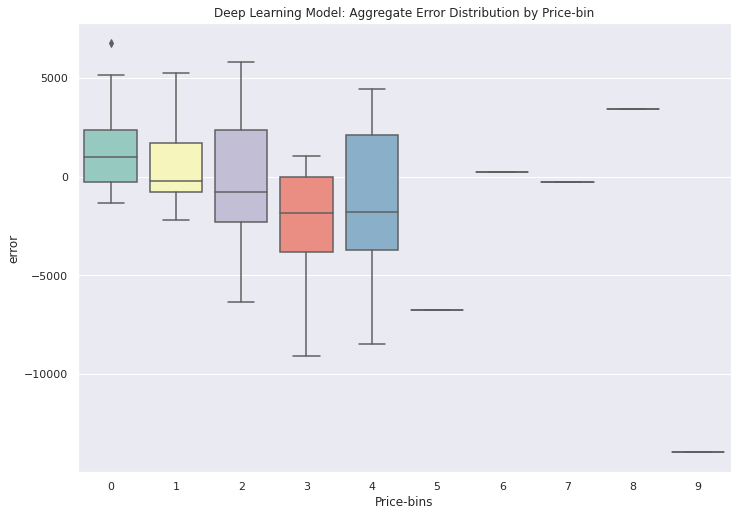

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="Price-bins", y="error", data=O_Test, palette="Set3").set(title='Deep Learning Model: Aggregate Error Distribution by Price-bin')

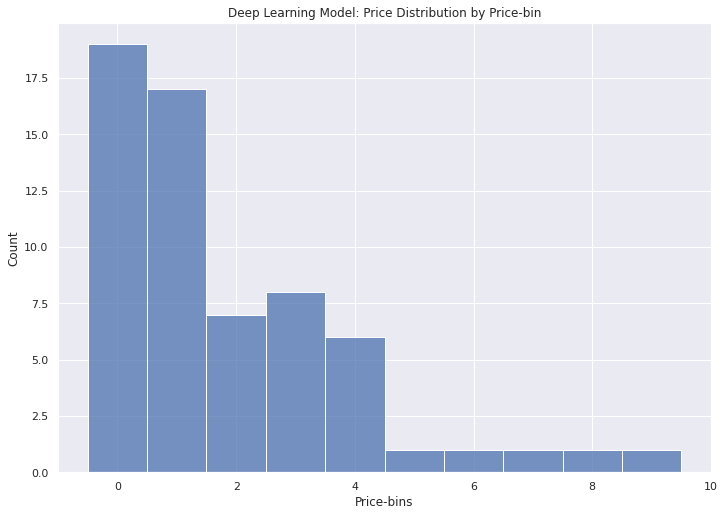

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.histplot(data=O_Test, x="Price-bins", palette="Set3").set(title='Deep Learning Model: Price Distribution by Price-bin')

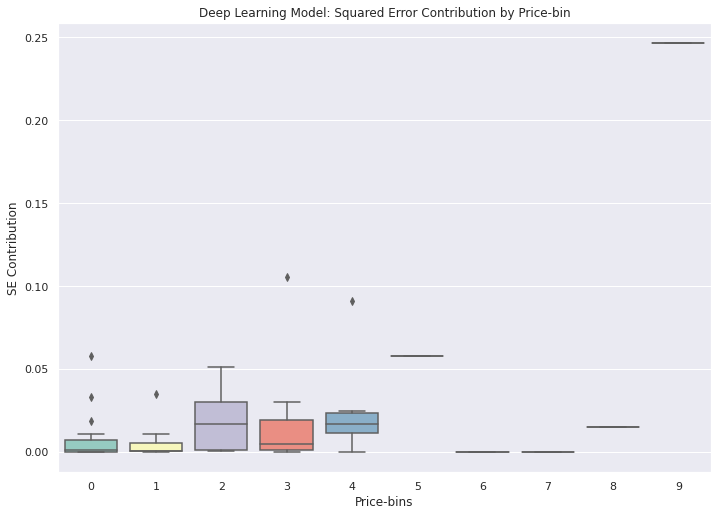

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="Price-bins", y="SE Contribution", data=O_Test, palette="Set3").set(title='Deep Learning Model: Squared Error Contribution by Price-bin')

In [ ]:
import matplotlib.pyplot as plt


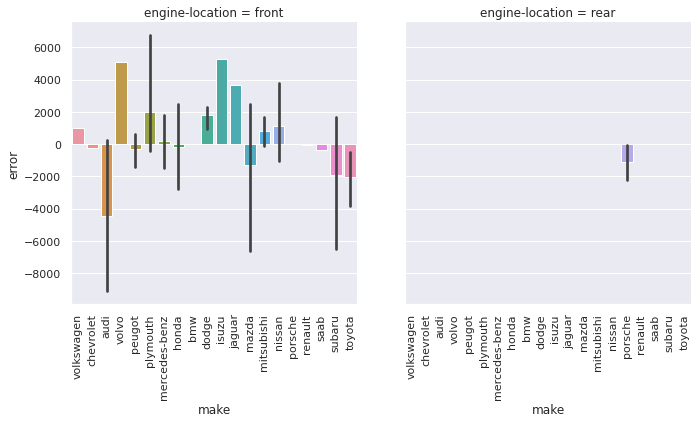

In [ ]:

graph=sns.catplot(data=O_Test, x="make", y="error", col="engine-location",
    kind="bar")
graph.set_xticklabels(rotation=90)

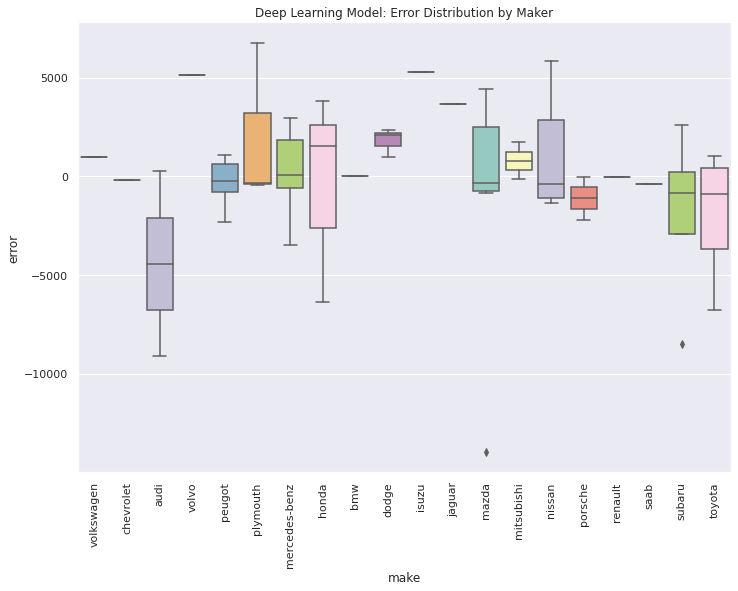

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
ax = sns.boxplot(x="make", y="error", data=O_Test, palette="Set3").set(title='Deep Learning Model: Error Distribution by Maker')

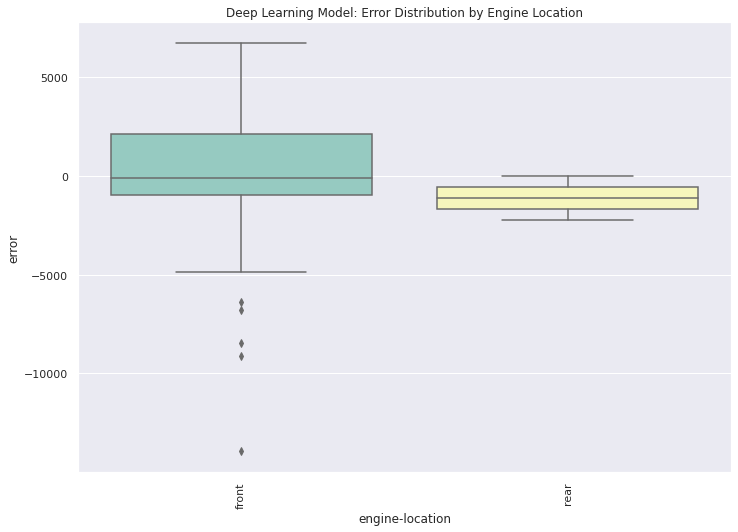

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
ax = sns.boxplot(x="engine-location", y="error", data=O_Test, palette="Set3").set(title='Deep Learning Model: Error Distribution by Engine Location')

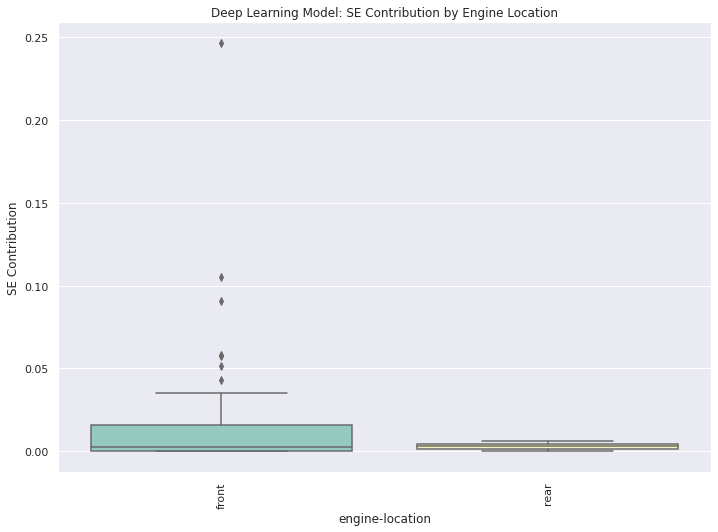

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
ax = sns.boxplot(x="engine-location", y="SE Contribution", data=O_Test, palette="Set3").set(title='Deep Learning Model: SE Contribution by Engine Location')

In [ ]:
px.treemap(data_frame=O_Test, path=[px.Constant('Deep Learning Model: Aggregate Distribution of Squared Error by engine-location'), 'engine-location', 'make'], values='SE Contribution', color='SE Contribution')